In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px # this is another plotting library for interactive plot

from sklearn.model_selection import train_test_split
from sklearn import metrics, manifold # we will use the metrics and manifold learning modules from scikit-learn
from pathlib import Path # to interact with file paths
from PIL import Image # to interact with images
from tqdm import tqdm # progress bar
from pprint import pprint # pretty print (useful for a more readable print of objects like lists or dictionaries)
from IPython.display import clear_output # to clear the output of the notebook

import torch
import torch.nn as nn
import torchvision
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
import os
import shutil

from Simulator.src.helper_functions import *


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device("cpu")


/home/irong/dlenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# DEFINITIONS
IN, OUT, CONV_LAYERS, FC_LAYERS, DROPOUT = 'IN', 'OUT', 'CONV_LAYERS', 'FC_LAYERS', 'DROPOUT'


MODEL_FOLDER = 'Simulator/models'
model_name = MODEL_FOLDER + '/lane_keeper.pt'
onnx_lane_keeper_path = MODEL_FOLDER + '/lane_keeper.onnx'

In [3]:
# NETWORK ARCHITECTURE
DROPOUT_PROB = 0.3
DEFAULT_CONV_LAYERS = nn.Sequential( #in = 32x32
            nn.Conv2d(1, 4, 5, 1), #out = 28
            nn.ReLU(True),
            nn.Dropout(p=DROPOUT_PROB),
            nn.MaxPool2d(2, 2), #out=14
            nn.BatchNorm2d(4),
            nn.Dropout(p=DROPOUT_PROB),
            nn.Conv2d(4, 4, 5, 1), #out = 10
            nn.ReLU(True),
            nn.Dropout(p=DROPOUT_PROB),
            nn.MaxPool2d(2, 2), #out=5
            nn.Dropout(p=DROPOUT_PROB),
            nn.Conv2d(4, 32, 5, 1), #out = 1
            nn.ReLU(True),
        )
DEFAULT_FC_LAYERS = nn.Sequential(
            nn.Linear(1*1*32, 16),
            nn.ReLU(True),
            # nn.Tanh(),
            nn.Linear(16, 1),
        )

NET_PARAMS = {IN:32, OUT:1, CONV_LAYERS:DEFAULT_CONV_LAYERS, FC_LAYERS:DEFAULT_FC_LAYERS, DROPOUT:DROPOUT_PROB}


class HEstimator(nn.Module):
    def __init__(self, net_params=NET_PARAMS):
        super().__init__()
        self.conv = net_params[CONV_LAYERS]
        self.flatten = nn.Flatten()
        self.lin = net_params[FC_LAYERS]

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.lin(x)
        return x

In [4]:
# IMAGE PREPROCESSING AND AUGMENTATION
import cv2 as cv
import numpy as np
from numpy.random import randint
from time import time, sleep

def preprocess_image(img, size=32, keep_bottom=0.66666667, canny1=100, canny2=200, blur=3):
    """
    Preprocesses an image to be used as input for the network.
    Note: the function modifies the image in place
    """
    #set associated parameters to None to skip the step
    skip_canny = canny1 == None or canny2 == None
    skip_blur = blur == None
    #check if its a valid image
    assert len(img.shape) == 3 or len(img.shape) == 2, "Invalid image shape"
    #check if the imge is grayscale
    img_is_gray = len(img.shape) == 2
    if not img_is_gray:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #cut the top part
    img = img[int(img.shape[0]*(1-keep_bottom)):,:]
    #resize 1
    img = cv.resize(img, (2*size, 2*size))
    #canny
    if not skip_canny:
        img = cv.Canny(img, canny1, canny2)
    #blur
    if not skip_blur:
        img = cv.blur(img, (3,3), 0)
    #resize 2
    img = cv.resize(img, (size, size))
    return img

def augment_img(img, size=32, keep_bottom=0.66666667, canny1=100, canny2=200, blur=3, 
                max_tilt_fraction=0.1, noise_std=80):
    """
    Augments an image by applying random transformations
    Note: the function modifies the image in place
    """

    # preaugmentation
    img = cv.resize(img, (4*size, 4*size)) # 128x128

    #create random ellipses to simulate light from the sun
    light = np.zeros(img.shape, dtype=np.uint8)
    #add ellipses
    for j in range(2):
        cent = (randint(0, img.shape[0]), randint(0, img.shape[1]))
        axes_length = (randint(int(4*size/42.67),int(4*size/10.67)), randint(int(4*size/10.67), int(size*4/1.70))) #(randint(3, 12), randint(12, 75))
        angle = randint(0, 360)
        light = cv.ellipse(light, cent, axes_length, angle, 0, 360, 255, -1)
    #create an image of random white and black pixels
    light = cv.blur(light, (50,50))
    noise = randint(0, 2, size=img.shape, dtype=np.uint8)*255
    light = cv.subtract(light, noise)
    light = np.clip(light, 0, 51)
    light *= 5
    #add light to the image
    img = cv.add(img, light)

    # dilation/erosion
    r = randint(0, 5)
    if r == 0:
        #dilate
        kernel = np.ones((randint(1, 5), randint(1, 5)), np.uint8)
        img = cv.dilate(img, kernel, iterations=1)
    elif r == 1:
        #erode
        kernel = np.ones((randint(1, 5), randint(1, 5)), np.uint8)
        img = cv.erode(img, kernel, iterations=1)

    #preprocessing
    img = preprocess_image(img, size, keep_bottom, canny1, canny2, blur)

    # second augmentation
    #add random tilt
    max_offset = int(size*max_tilt_fraction)
    offset = randint(-max_offset, max_offset)
    img = np.roll(img, offset, axis=0)
    if offset > 0:
        img[:offset, :] = 0 #randint(0,255)
    elif offset < 0:
        img[offset:, :] = 0 # randint(0,255)

    #add noise 
    std = noise_std
    std = randint(1, std)
    noisem = randint(0, std, img.shape, dtype=np.uint8)
    img = cv.subtract(img, noisem)
    noisep = randint(0, std, img.shape, dtype=np.uint8)
    img = cv.add(img, noisep)

    return img


In [5]:
# DATASET
class MyDataset(Dataset):
    def __init__(self, dataset_file_path, he_distances=[0.5], size=32, keep_bottom=0.66666667, canny1=100, canny2=200, blur=3, 
                max_tilt_fraction=0.1, noise_std=80):

        self.data = []
        print('decompressing...')
        path = path = np.load('sparcs/sparcs_path_precise.npy').T
        log = np.load(f'{dataset_file_path}.npz')
        imgs, locs = log['imgs'],log['locs']
        assert len(imgs) == len(locs), f'Invalid dataset, imgs and locs have different lengths: {len(imgs)} != {len(locs)}'
        assert locs.shape[1] == 3, f'Invalid dataset, locs must have shape (N,2), got {locs.shape}'
        dataset_length = len(imgs)
        print(f'Dataset: {dataset_file_path}\nDataset length: {dataset_length}')
        self.imgs = torch.zeros((2*dataset_length, size, size, 1), dtype=torch.uint8)
        # cv.namedWindow('img', cv.WINDOW_NORMAL)
        # cv.resizeWindow('img', 600, 600)
        for i, (img, (x,y,yaw)) in tqdm(enumerate(zip(imgs,locs))):
            hes = []
            for d in he_distances:
                he, _, _ = get_heading_error(x,y,yaw, path,d)
                hes.append(he)
            hes = np.array(hes)
            self.data.append(hes)
            self.data.append(-hes)
            img = augment_img(img, size, keep_bottom, canny1, canny2, blur, max_tilt_fraction, noise_std)
            fimg = cv.flip(img, 1)
            img = img[:, :,np.newaxis]
            fimg = fimg[:, :,np.newaxis]
            img = torch.from_numpy(img)
            fimg = torch.from_numpy(fimg)
            self.imgs[2*i] = img
            self.imgs[2*i+1] = fimg
            # cv.imshow('img', self.imgs[i])
            # if cv.waitKey(100) == 27:
            #     cv.destroyAllWindows()  
            #     break
        self.data = torch.from_numpy(np.array(self.data))
        #put data on gpu
        self.imgs = self.imgs.to(device)
        self.data = self.data.to(device)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = img.permute(2, 0, 1).float()
        value = self.data[idx].float()
        return img, value


In [6]:
lane_keeper_ahead = HEstimator()
lane_keeper_ahead.to(device)

name_dataset = 'saved_tests/train18' #saved_tests/sim_dataset0'
#create dataset #takes a long time but then training is faster
train_dataset = MyDataset(name_dataset, he_distances=[0.8])

#split dataset into train and val
train_size = int(0.9*len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# DATALOADERS
train_dataloader = DataLoader(train_dataset, batch_size=8*8192, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8192, shuffle=False)

decompressing...
Dataset: saved_tests/train18
Dataset length: 9805


9805it [00:09, 1018.44it/s]


In [7]:
#test dataloader
sample = next(iter(train_dataloader))
print(sample[0].shape)
print(sample[1].shape)

torch.Size([17649, 1, 32, 32])
torch.Size([17649, 1])


In [8]:
# TRAINING FUNCTION
def train_epoch(model, dataloader, regr_loss_fn, optimizer, L1_lambda=0.0, L2_lambda=0.0,  device=device):
    # Set the model to training mode
    model.train() #train
    # Initialize the loss
    he_losses = []
    # Loop over the training batches
    for (input, regr_label) in tqdm(dataloader):
        # Zero the gradients
        optimizer.zero_grad()
        # Compute the output
        output = model(input)
        he = output[:, 0]
        he_label = regr_label[:, 0]
        # Compute the losses
        he_loss = 1.0*regr_loss_fn(he, he_label)
        #L1 regularization
        L1_norm = sum(p.abs().sum() for p in model.conv.parameters())
        L1_loss = L1_lambda * L1_norm 
        #L2 regularization
        L2_norm = sum(p.pow(2).sum() for p in model.conv.parameters())
        L2_loss = L2_lambda * L2_norm
        #total loss
        loss = he_loss + L1_loss + L2_loss
        # Compute the gradients
        loss.backward()
        # Update the weights
        optimizer.step()
        #batch loss
        he_losses.append(he_loss.detach().cpu().numpy())

    # Return the average training loss
    he_loss = np.mean(he_losses)
    return he_loss

    # VALIDATION FUNCTION
def val_epoch(lane_keeper_ahead, val_dataloader, regr_loss_fn, device=device):
    lane_keeper_ahead.eval()
    he_losses = []
    for (input, regr_label) in tqdm(val_dataloader):
        output = lane_keeper_ahead(input)
        regr_out = output
        he = regr_out[:, 0]
        he_label = regr_label[:, 0]
        he_loss = 1.0*regr_loss_fn(he, he_label)
        he_losses.append(he_loss.detach().cpu().numpy())
    return np.mean(he_losses)

In [9]:
# TRAINING 
#parameters
lr = 0.003 #0.005
epochs = 500 #500
#regularization is applied only to convolutional section, add weight decay to apply it to all layers
L1_lambda = 1e-4 #9e-4
L2_lambda = 1e-2 #1e-2
optimizer = torch.optim.Adam(lane_keeper_ahead.parameters(), lr=lr, weight_decay=9e-5) #wd = 2e-3# 3e-5
regr_loss_fn1 = nn.MSELoss() #before epochs/2
regr_loss_fn2 = nn.MSELoss() #after epochs/2 for finetuning

best_val = 100
best_epoch = 0

for epoch in range(epochs):
    # try:
    if True:
        regr_loss_fn = regr_loss_fn1 if epoch < epochs//2 else regr_loss_fn2
        he_loss = train_epoch(lane_keeper_ahead, train_dataloader, regr_loss_fn, optimizer, L1_lambda, L2_lambda, device)
        val_he_loss = val_epoch(lane_keeper_ahead, val_dataloader, regr_loss_fn, device)
        clear_output(wait=False)
    # except Exception as e:
    #     print(e)
    #     torch.cuda.empty_cache()
    #     continue
    if val_he_loss < best_val:
        best_val = val_he_loss
        best_epoch = epoch
        torch.save(lane_keeper_ahead.state_dict(), model_name)
        print("model saved")
    
    print(f"Epoch  {epoch+1}/{epochs},  loss = {regr_loss_fn} \nhe_loss: {he_loss:.4f},   Val: {val_he_loss:.4f}, best_val: {best_val:.4f}, best_epoch: {best_epoch}")
    # print(f"lat_err_loss2: {err_loss2:.4f},   Val: {val_loss2:.4f}")
    # print(f"curv_loss: {curv_loss}")

#Note: sweet spot for training is around 0.016 -> 0.020, also note that training can get stuck, and loss can start improving randomly

Epoch  322/500,  loss = MSELoss() 
he_loss: 0.0686,   Val: 0.0667, best_val: 0.0622, best_epoch: 291


  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [10]:
# EVALUATE ON TEST SET (UNSEEN DATA)
lane_keeper_ahead.load_state_dict(torch.load(model_name))
he_loss = val_epoch(lane_keeper_ahead, val_dataloader, regr_loss_fn, device)

# print(f"lateral_err2_loss: {err_loss2}")
print(f"he loss: {he_loss}")

100%|██████████| 1/1 [00:00<00:00, 22.26it/s]

he loss: 0.062184207141399384


(4, 1, 5, 5)
(4, 4, 5, 5)
(32, 4, 5, 5)


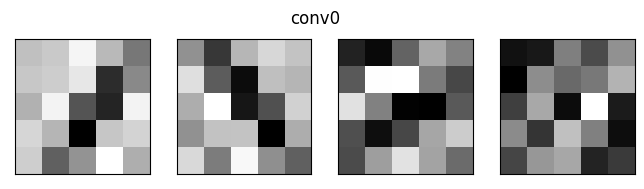

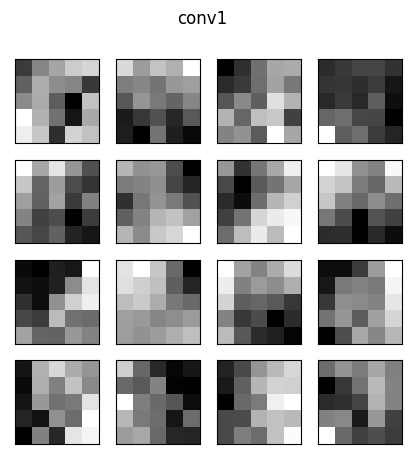

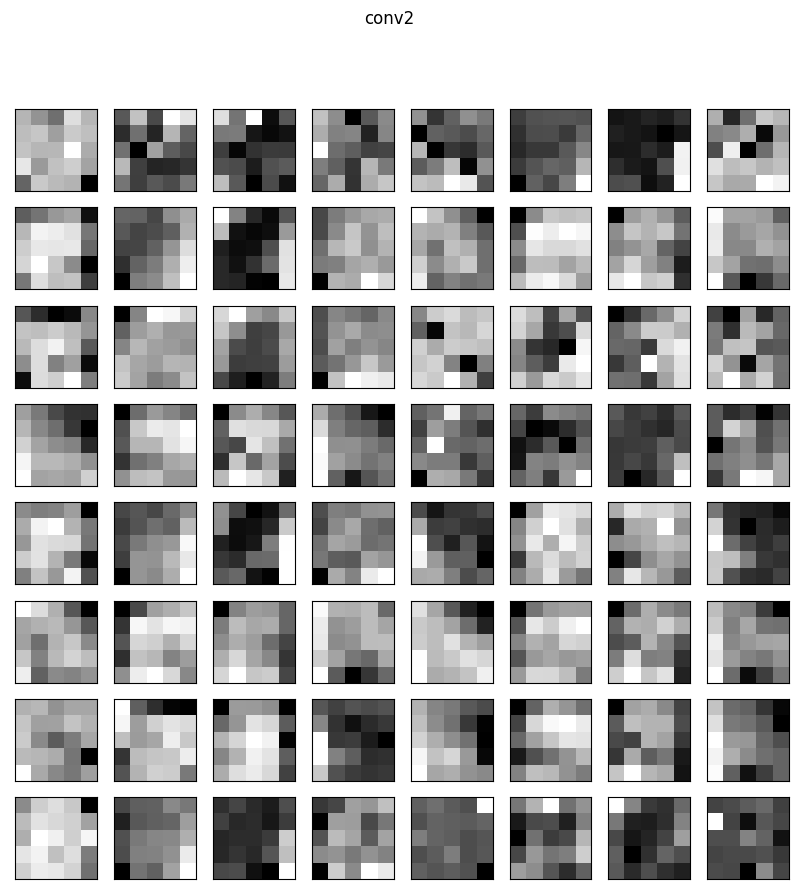

In [11]:
# VISUALIZE CONVOLUTIONAL FILTERS
conv_layers = []
children = list(lane_keeper_ahead.children())
for i in range(len(children)):
    if isinstance(children[i], nn.Conv2d):
        conv_layers.append(children[i])
    elif isinstance(children[i], nn.Sequential):
        for child in children[i].children():
            if isinstance(child, nn.Conv2d):
                conv_layers.append(child)

c0 = conv_layers[0].weight.data.cpu().numpy()
c1 = conv_layers[1].weight.data.cpu().numpy()
c2 = conv_layers[2].weight.data.cpu().numpy()

def plot_nchw_data(data, h_num, v_num, title, size=(10, 10)):
    fig, axs = plt.subplots(h_num, v_num, figsize=size)
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    #plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()
    return fig

# fig0 = plot_nchw_data(c0, 4, 4, 'conv0')
print(c0.shape)
print(c1.shape)
print(c2.shape)

fig0 = plot_nchw_data(c0, 1, 4, 'conv0', size=(8,2))

fig1 = plot_nchw_data(c1, 4, 4, 'conv1', size=(5,5)) 

fig2 = plot_nchw_data(c2, 8, 8, 'conv2', size=(10,10))



In [12]:
# CONVERT TO ONNX MODEL FOR OPENCV
lane_keeper_ahead.load_state_dict(torch.load(model_name))

#save the model so that opencv can load it
import torch
import torch.onnx
import torchvision
import torchvision.models as models
import sys

device = torch.device('cpu')
lane_keeper_ahead.to(device)

# set the model to inference mode
lane_keeper_ahead.eval()

# Create some sample input in the shape this model expects 
# This is needed because the convertion forward pass the network once 
dummy_input = torch.randn(1, 1, 32, 32)
torch.onnx.export(lane_keeper_ahead, dummy_input, onnx_lane_keeper_path, verbose=True)

clear_output(wait=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lane_keeper_ahead.to(device)

HEstimator(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv2d(4, 4, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.3, inplace=False)
    (11): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1))
    (12): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)